In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)']

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog']

In [4]:
p = Pipeline.objects.all()[31]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: dummy n3bgs frog
DataSource: N3BGS FROG Train
NLP Tool: Frog
Classifier: Support Vector
Task status: Status.SUCCESS


In [5]:
len(p.data_source.articles)

857

In [8]:
test_data_source = DataSource.objects.all()[29]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: N3BGS FROG Test


In [9]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7fb1b21a5990>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7fb1b21a5590>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7fb1b21a55d0>), ('Sentiment', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuot...a5a10>), ('Frog', <newsgac.nlp_tools.models.frog.FrogFeatureExtractor object at 0x7fb1d3b4de10>)]))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [10]:
# For NB change scaler to minMax
skp_opt.steps.pop()

('RobustScaler',
 RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
        with_scaling=True))

In [11]:
skp_opt.steps.append(('MinMaxScaler', MinMaxScaler(feature_range=(0, 1))))
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7fb1b21a5990>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7fb1b21a5590>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7fb1b21a55d0>), ('Sentiment', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuot...a5a10>), ('Frog', <newsgac.nlp_tools.models.frog.FrogFeatureExtractor object at 0x7fb1d3b4de10>)]))],
         transformer_weights=None)),
 ('MinMaxScaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]

In [12]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [13]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [14]:
X_train = X
y_train = labels
y_test = labels_test

In [15]:
y_test.shape

(95,)

In [16]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'alpha': hp.uniform('alpha', 0.0, 5.0),
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [17]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    
    model = MultinomialNB(alpha=params['alpha'])

    model.fit(X_train, y_train)   

    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [18]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
print('\n Best score:')
score(best_param)

Hyperopt:   3%|▎         | 27/1000 [00:00<00:07, 138.97it/s]

Parameters with this training accuracy 0.351225204201 and loss 2.60200443022 :
Parameters with this testing accuracy 0.284210526316 and loss 2.63585188496 :
{'alpha': 4.234841084429139}
Parameters with this training accuracy 0.358226371062 and loss 2.58472843474 :
Parameters with this testing accuracy 0.273684210526 and loss 2.62184069909 :
{'alpha': 3.298055416489141}
Parameters with this training accuracy 0.354725787631 and loss 2.60049297306 :
Parameters with this testing accuracy 0.284210526316 and loss 2.63462837112 :
{'alpha': 4.143952857567568}
Parameters with this training accuracy 0.380396732789 and loss 2.48291842718 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53815986223 :
{'alpha': 0.45526637170250683}
Parameters with this training accuracy 0.357059509918 and loss 2.56587730846 :
Parameters with this testing accuracy 0.273684210526 and loss 2.60648324174 :
{'alpha': 2.487536794363725}
Parameters with this training accuracy 0.359393232205 and loss 2.561

Hyperopt:   5%|▌         | 51/1000 [00:00<00:07, 124.57it/s]

Parameters with this training accuracy 0.379229871645 and loss 2.49071311645 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54461647485 :
{'alpha': 0.5749735964474878}
Parameters with this training accuracy 0.376896149358 and loss 2.49854560826 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55109866464 :
{'alpha': 0.7066972879321246}
Parameters with this training accuracy 0.388564760793 and loss 2.46099604769 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51995956667 :
{'alpha': 0.17378411423470286}
Parameters with this training accuracy 0.381563593932 and loss 2.48081863832 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53641952456 :
{'alpha': 0.424862624506775}
Parameters with this training accuracy 0.378063010502 and loss 2.49494559775 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54812000706 :
{'alpha': 0.644677699920006}
Parameters with this training accuracy 0.357059509918 and loss 2.5

Hyperopt:   7%|▋         | 74/1000 [00:00<00:07, 118.28it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.51200012097 :
Parameters with this testing accuracy 0.315789473684 and loss 2.562219139 :
{'alpha': 0.9623412655941994}
Parameters with this training accuracy 0.372228704784 and loss 2.53942744188 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58481522009 :
{'alpha': 1.6210698324878385}
Parameters with this training accuracy 0.361726954492 and loss 2.55772894888 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59982252671 :
{'alpha': 2.1912156000543854}
Parameters with this training accuracy 0.357059509918 and loss 2.57109663866 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61074258758 :
{'alpha': 2.693292121257853}
Parameters with this training accuracy 0.375729288215 and loss 2.50168551968 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55369559831 :
{'alpha': 0.7629139368043439}
Parameters with this training accuracy 0.369894982497 and loss 2.548

Hyperopt:   8%|▊         | 85/1000 [00:00<00:08, 108.73it/s]

Parameters with this training accuracy 0.369894982497 and loss 2.54986400449 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59338099194 :
{'alpha': 1.9312021976555522}
Parameters with this training accuracy 0.380396732789 and loss 2.48491204876 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53981179877 :
{'alpha': 0.48484561405742055}
Parameters with this training accuracy 0.38739789965 and loss 2.46029292459 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51937412574 :
{'alpha': 0.16602391507241387}
Parameters with this training accuracy 0.376896149358 and loss 2.50666098412 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55780858048 :
{'alpha': 0.8562073891827096}
Parameters with this training accuracy 0.376896149358 and loss 2.49748537392 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55022155387 :
{'alpha': 0.6881654857165697}
Parameters with this training accuracy 0.388564760793 and loss 2

Hyperopt:  11%|█         | 110/1000 [00:00<00:08, 108.60it/s]

Parameters with this training accuracy 0.366394399067 and loss 2.55143537988 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59466893592 :
{'alpha': 1.981245255725819}
Parameters with this training accuracy 0.375729288215 and loss 2.50046582333 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55268693868 :
{'alpha': 0.7408373277730815}
Parameters with this training accuracy 0.357059509918 and loss 2.56623321041 :
Parameters with this testing accuracy 0.273684210526 and loss 2.60677386027 :
{'alpha': 2.5011547565433467}
Parameters with this training accuracy 0.374562427071 and loss 2.52418325047 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57226998408 :
{'alpha': 1.229871628872117}
Parameters with this training accuracy 0.357059509918 and loss 2.57947716209 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61756997678 :
{'alpha': 3.0527190929253787}
Parameters with this training accuracy 0.394399066511 and loss 2.45

Hyperopt:  14%|█▎        | 136/1000 [00:01<00:07, 116.74it/s]

Parameters with this training accuracy 0.357059509918 and loss 2.58877370085 :
Parameters with this testing accuracy 0.284210526316 and loss 2.6251267846 :
{'alpha': 3.4986558193967436}
Parameters with this training accuracy 0.371061843641 and loss 2.53850782234 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58405950608 :
{'alpha': 1.5954922542250154}
Parameters with this training accuracy 0.341890315053 and loss 2.61322171011 :
Parameters with this testing accuracy 0.284210526316 and loss 2.64491924713 :
{'alpha': 4.972667894183772}
Parameters with this training accuracy 0.385064177363 and loss 2.46537060325 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5235985818 :
{'alpha': 0.22379125596922322}
Parameters with this training accuracy 0.375729288215 and loss 2.52842995566 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57576853004 :
{'alpha': 1.3321265443181405}
Parameters with this training accuracy 0.359393232205 and loss 2.57

Hyperopt:  16%|█▌        | 161/1000 [00:01<00:07, 117.02it/s]

Parameters with this training accuracy 0.372228704784 and loss 2.54213027947 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58703546459 :
{'alpha': 1.6978294292838836}
Parameters with this training accuracy 0.380396732789 and loss 2.48915729404 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54332818904 :
{'alpha': 0.5501983656020696}
Parameters with this training accuracy 0.380396732789 and loss 2.48610229466 :
Parameters with this testing accuracy 0.315789473684 and loss 2.54079786607 :
{'alpha': 0.5028409139547075}
Parameters with this training accuracy 0.374562427071 and loss 2.50819566291 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55907668461 :
{'alpha': 0.8860613345629791}
Parameters with this training accuracy 0.374562427071 and loss 2.52766927294 :
Parameters with this testing accuracy 0.326315789474 and loss 2.5751420605 :
{'alpha': 1.313446742797923}
Parameters with this training accuracy 0.375729288215 and loss 2.53

Hyperopt:  19%|█▊        | 186/1000 [00:01<00:07, 113.31it/s]

Parameters with this training accuracy 0.388564760793 and loss 2.45913346223 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51840833535 :
{'alpha': 0.15339439059062243}
Parameters with this training accuracy 0.374562427071 and loss 2.52304164795 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57132904657 :
{'alpha': 1.2032113603535428}
Parameters with this training accuracy 0.376896149358 and loss 2.50458824799 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55609546758 :
{'alpha': 0.8167013065355286}
Parameters with this training accuracy 0.378063010502 and loss 2.49175847586 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54548194994 :
{'alpha': 0.5918734976913945}
Parameters with this training accuracy 0.376896149358 and loss 2.49912202278 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55157547473 :
{'alpha': 0.7168670546782535}
Parameters with this training accuracy 0.375729288215 and loss 2

Hyperopt:  21%|██        | 211/1000 [00:01<00:07, 110.48it/s]

Parameters with this training accuracy 0.361726954492 and loss 2.55844842548 :
Parameters with this testing accuracy 0.284210526316 and loss 2.60041118527 :
{'alpha': 2.2162314648920622}
Parameters with this training accuracy 0.386231038506 and loss 2.46803557014 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52581312931 :
{'alpha': 0.25572455443153413}
Parameters with this training accuracy 0.390898483081 and loss 2.44697314748 :
Parameters with this testing accuracy 0.294736842105 and loss 2.50823143256 :
{'alpha': 0.03358094076616425}
Parameters with this training accuracy 0.374562427071 and loss 2.52585920063 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57365099865 :
{'alpha': 1.2696397806950537}
Parameters with this training accuracy 0.372228704784 and loss 2.53944052603 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58482597116 :
{'alpha': 1.6214356973858295}
Parameters with this training accuracy 0.365227537923 and loss 

Hyperopt:  22%|██▏       | 223/1000 [00:01<00:07, 101.71it/s]

Parameters with this training accuracy 0.361726954492 and loss 2.56043323179 :
Parameters with this testing accuracy 0.284210526316 and loss 2.60203457097 :
{'alpha': 2.2863654223879}
Parameters with this training accuracy 0.386231038506 and loss 2.47334607817 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53022214228 :
{'alpha': 0.32273335593917996}
Parameters with this training accuracy 0.359393232205 and loss 2.57459856226 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61359726999 :
{'alpha': 2.83893330237791}
Parameters with this training accuracy 0.365227537923 and loss 2.55252089035 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59555837442 :
{'alpha': 2.0163577162984025}
Parameters with this training accuracy 0.375729288215 and loss 2.52789553386 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57532840974 :
{'alpha': 1.3189861192810723}
Parameters with this training accuracy 0.374562427071 and loss 2.5271

Hyperopt:  25%|██▍       | 246/1000 [00:02<00:07, 106.07it/s]

Parameters with this training accuracy 0.364060676779 and loss 2.55551912205 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59801385798 :
{'alpha': 2.115704338627396}
Parameters with this training accuracy 0.357059509918 and loss 2.58858596534 :
Parameters with this testing accuracy 0.284210526316 and loss 2.62497435466 :
{'alpha': 3.4891113734303967}
Parameters with this training accuracy 0.372228704784 and loss 2.54412809342 :
Parameters with this testing accuracy 0.294736842105 and loss 2.58867572759 :
{'alpha': 1.7561245177540634}
Parameters with this training accuracy 0.369894982497 and loss 2.54839295801 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59217485463 :
{'alpha': 1.8851805505054382}
Parameters with this training accuracy 0.375729288215 and loss 2.53098405674 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57787133147 :
{'alpha': 1.396039866219351}
Parameters with this training accuracy 0.374562427071 and loss 2.52

Hyperopt:  27%|██▋       | 268/1000 [00:02<00:07, 103.81it/s]

Parameters with this training accuracy 0.357059509918 and loss 2.5808661879 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61870018377 :
{'alpha': 3.1160273799128615}
Parameters with this training accuracy 0.375729288215 and loss 2.51301429068 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56305654493 :
{'alpha': 0.9832348596520541}
Parameters with this training accuracy 0.374562427071 and loss 2.52337133479 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57160080213 :
{'alpha': 1.210875351011513}
Parameters with this training accuracy 0.371061843641 and loss 2.53904448739 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58450053821 :
{'alpha': 1.6103858080463445}
Parameters with this training accuracy 0.376896149358 and loss 2.50618059766 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55741158361 :
{'alpha': 0.846968535371238}
Parameters with this training accuracy 0.376896149358 and loss 2.496

Hyperopt:  29%|██▉       | 290/1000 [00:02<00:06, 102.62it/s]

Parameters with this training accuracy 0.373395565928 and loss 2.53447203305 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58074130737 :
{'alpha': 1.486376895452996}
Parameters with this training accuracy 0.376896149358 and loss 2.50684403341 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55795984781 :
{'alpha': 0.8597410581020275}
Parameters with this training accuracy 0.371061843641 and loss 2.54325004933 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58795491696 :
{'alpha': 1.7303378377499374}
Parameters with this training accuracy 0.375729288215 and loss 2.513672619 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56360006298 :
{'alpha': 0.9969260927153196}
Parameters with this training accuracy 0.364060676779 and loss 2.55582157491 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59826146236 :
{'alpha': 2.1259228689532685}
Parameters with this training accuracy 0.385064177363 and loss 2.474

Hyperopt:  31%|███▏      | 313/1000 [00:02<00:06, 105.34it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.5321095789 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57879764955 :
{'alpha': 1.424799112619863}
Parameters with this training accuracy 0.372228704784 and loss 2.5395750699 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58493652234 :
{'alpha': 1.625201067137324}
Parameters with this training accuracy 0.36756126021 and loss 2.55122362474 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59449540293 :
{'alpha': 1.9744477200130932}
Parameters with this training accuracy 0.375729288215 and loss 2.53010379192 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57714672199 :
{'alpha': 1.3738025627110226}
Parameters with this training accuracy 0.375729288215 and loss 2.5206394874 :
Parameters with this testing accuracy 0.326315789474 and loss 2.56934851749 :
{'alpha': 1.1482237436009992}
Parameters with this training accuracy 0.364060676779 and loss 2.555710

Hyperopt:  34%|███▎      | 336/1000 [00:03<00:06, 106.69it/s]

Parameters with this training accuracy 0.378063010502 and loss 2.49410121943 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54742118753 :
{'alpha': 0.6304984818278346}
Parameters with this training accuracy 0.376896149358 and loss 2.50641269488 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55760339459 :
{'alpha': 0.851425984931989}
Parameters with this training accuracy 0.386231038506 and loss 2.47009215868 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52752115844 :
{'alpha': 0.28113745237857085}
Parameters with this training accuracy 0.345390898483 and loss 2.61041449758 :
Parameters with this testing accuracy 0.284210526316 and loss 2.64265214594 :
{'alpha': 4.77690021084684}
Parameters with this training accuracy 0.362893815636 and loss 2.55761460531 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59972896406 :
{'alpha': 2.187259612412112}
Parameters with this training accuracy 0.394399066511 and loss 2.452

Hyperopt:  36%|███▌      | 358/1000 [00:03<00:06, 103.84it/s]

Parameters with this training accuracy 0.381563593932 and loss 2.47849174717 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53449041807 :
{'alpha': 0.39205538587406746}
Parameters with this training accuracy 0.390898483081 and loss 2.44723543023 :
Parameters with this testing accuracy 0.294736842105 and loss 2.50845239929 :
{'alpha': 0.03591480062808361}
Parameters with this training accuracy 0.373395565928 and loss 2.534723822 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58094840698 :
{'alpha': 1.4930381997681783}
Parameters with this training accuracy 0.38739789965 and loss 2.46472329887 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52306044026 :
{'alpha': 0.21620346734737966}
Parameters with this training accuracy 0.359393232205 and loss 2.5628075634 :
Parameters with this testing accuracy 0.284210526316 and loss 2.60397551275 :
{'alpha': 2.3724825770166413}
Parameters with this training accuracy 0.386231038506 and loss 2.4

Hyperopt:  38%|███▊      | 380/1000 [00:03<00:06, 97.30it/s] 

Parameters with this training accuracy 0.371061843641 and loss 2.54701213279 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59104232042 :
{'alpha': 1.8426940563955498}
Parameters with this training accuracy 0.376896149358 and loss 2.50411592033 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55570502473 :
{'alpha': 0.8078279120524737}
Parameters with this training accuracy 0.371061843641 and loss 2.53674649398 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58261169437 :
{'alpha': 1.5472509276255844}
Parameters with this training accuracy 0.372228704784 and loss 2.54246090663 :
Parameters with this testing accuracy 0.305263157895 and loss 2.5873069688 :
{'alpha': 1.7073842864489726}
Parameters with this training accuracy 0.374562427071 and loss 2.5210256209 :
Parameters with this testing accuracy 0.326315789474 and loss 2.56966693089 :
{'alpha': 1.1569623468927253}
Parameters with this training accuracy 0.374562427071 and loss 2.51

Hyperopt:  39%|███▉      | 390/1000 [00:03<00:06, 96.41it/s]

Parameters with this training accuracy 0.375729288215 and loss 2.5022741649 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5541823395 :
{'alpha': 0.7736785881359174}
Parameters with this training accuracy 0.374562427071 and loss 2.53288422257 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57943507154 :
{'alpha': 1.4448079101106095}
Parameters with this training accuracy 0.376896149358 and loss 2.51646931815 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56590841983 :
{'alpha': 1.0562361497652812}
Parameters with this training accuracy 0.393232205368 and loss 2.45463971399 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51465965181 :
{'alpha': 0.10641177973537341}
Parameters with this training accuracy 0.371061843641 and loss 2.54691795255 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59096506206 :
{'alpha': 1.839821038042043}
Parameters with this training accuracy 0.359393232205 and loss 2.57

Hyperopt:  41%|████      | 411/1000 [00:03<00:06, 95.90it/s]

Parameters with this training accuracy 0.366394399067 and loss 2.55180821267 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59497445082 :
{'alpha': 1.993254656155353}
Parameters with this training accuracy 0.381563593932 and loss 2.47854228662 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53453232407 :
{'alpha': 0.39275817501248433}
Parameters with this training accuracy 0.388564760793 and loss 2.46055179339 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51958968733 :
{'alpha': 0.16887207946492477}
Parameters with this training accuracy 0.374562427071 and loss 2.52038094356 :
Parameters with this testing accuracy 0.326315789474 and loss 2.56913530551 :
{'alpha': 1.1423938894562853}
Parameters with this training accuracy 0.380396732789 and loss 2.48888480682 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54310253515 :
{'alpha': 0.5459052531586233}
Parameters with this training accuracy 0.380396732789 and loss 2

Hyperopt:  43%|████▎     | 433/1000 [00:04<00:06, 94.18it/s]

Parameters with this training accuracy 0.380396732789 and loss 2.48252939198 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53783745765 :
{'alpha': 0.44957560150738773}
Parameters with this training accuracy 0.375729288215 and loss 2.53128854405 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57812194821 :
{'alpha': 1.4037837968887783}
Parameters with this training accuracy 0.375729288215 and loss 2.52866166377 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57595933835 :
{'alpha': 1.3378486154884617}
Parameters with this training accuracy 0.385064177363 and loss 2.47515011234 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53171895195 :
{'alpha': 0.34653767776835764}
Parameters with this training accuracy 0.371061843641 and loss 2.53575144464 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58179352972 :
{'alpha': 1.520424410326604}
Parameters with this training accuracy 0.374562427071 and loss 2

Hyperopt:  45%|████▌     | 454/1000 [00:04<00:05, 93.26it/s]

Parameters with this training accuracy 0.365227537923 and loss 2.55440737391 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59710356615 :
{'alpha': 2.0784558951426813}
Parameters with this training accuracy 0.371061843641 and loss 2.53594434405 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58195215151 :
{'alpha': 1.5256011444808637}
Parameters with this training accuracy 0.372228704784 and loss 2.5440315022 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58859644006 :
{'alpha': 1.7532749567664028}
Parameters with this training accuracy 0.372228704784 and loss 2.53978702913 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58511067725 :
{'alpha': 1.6311448212271196}
Parameters with this training accuracy 0.371061843641 and loss 2.54654676686 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59066055326 :
{'alpha': 1.8285284101215993}
Parameters with this training accuracy 0.378063010502 and loss 2.4

Hyperopt:  46%|████▋     | 464/1000 [00:04<00:06, 86.25it/s]

Parameters with this training accuracy 0.376896149358 and loss 2.50324718156 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55498683263 :
{'alpha': 0.7916309866473172}
Parameters with this training accuracy 0.371061843641 and loss 2.53781214259 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58348772116 :
{'alpha': 1.5763217123847868}
Parameters with this training accuracy 0.374562427071 and loss 2.5095443284 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56019086571 :
{'alpha': 0.9127279386724361}
Parameters with this training accuracy 0.368728121354 and loss 2.54997448677 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59347156177 :
{'alpha': 1.9346906769852397}
Parameters with this training accuracy 0.375729288215 and loss 2.49687509321 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54971663134 :
{'alpha': 0.6775999318724945}
Parameters with this training accuracy 0.374562427071 and loss 2.5

Hyperopt:  48%|████▊     | 485/1000 [00:04<00:05, 89.66it/s]

Parameters with this training accuracy 0.385064177363 and loss 2.47741357543 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53359635621 :
{'alpha': 0.37716514629963716}
Parameters with this training accuracy 0.374562427071 and loss 2.51034271159 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56085033966 :
{'alpha': 0.928706615216287}
Parameters with this training accuracy 0.365227537923 and loss 2.55272102571 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59572233519 :
{'alpha': 2.0228804379085914}
Parameters with this training accuracy 0.375729288215 and loss 2.5183977828 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56749955831 :
{'alpha': 1.0982373703037345}
Parameters with this training accuracy 0.375729288215 and loss 2.5316240113 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57839804665 :
{'alpha': 1.4123467436704575}
Parameters with this training accuracy 0.376896149358 and loss 2.49

Hyperopt:  50%|█████     | 505/1000 [00:04<00:05, 89.62it/s]

Parameters with this training accuracy 0.361726954492 and loss 2.55945302896 :
Parameters with this testing accuracy 0.284210526316 and loss 2.6012329553 :
{'alpha': 2.251521795020207}
Parameters with this training accuracy 0.38739789965 and loss 2.45827230288 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51769068211 :
{'alpha': 0.14414875401515093}
Parameters with this training accuracy 0.386231038506 and loss 2.44307689505 :
Parameters with this testing accuracy 0.294736842105 and loss 2.50493436599 :
{'alpha': 0.00033760088509038333}
Parameters with this training accuracy 0.376896149358 and loss 2.50581829295 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55711215408 :
{'alpha': 0.840033814857648}
Parameters with this training accuracy 0.38739789965 and loss 2.47085495047 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52815447985 :
{'alpha': 0.2907350804271862}
Parameters with this training accuracy 0.385064177363 and loss 2.

Hyperopt:  52%|█████▎    | 525/1000 [00:05<00:05, 87.47it/s]

Parameters with this training accuracy 0.375729288215 and loss 2.50295274823 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55474340465 :
{'alpha': 0.7861776636945834}
Parameters with this training accuracy 0.380396732789 and loss 2.48414841349 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5391790882 :
{'alpha': 0.4734328434923656}
Parameters with this training accuracy 0.386231038506 and loss 2.46669732734 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52470126008 :
{'alpha': 0.239548893203814}
Parameters with this training accuracy 0.38739789965 and loss 2.45790514033 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51738461043 :
{'alpha': 0.1402416761550792}
Parameters with this training accuracy 0.374562427071 and loss 2.50913264625 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55985078243 :
{'alpha': 0.9045447709041428}
Parameters with this training accuracy 0.380396732789 and loss 2.487

Hyperopt:  54%|█████▍    | 544/1000 [00:05<00:05, 90.46it/s]

Parameters with this training accuracy 0.359393232205 and loss 2.5763795558 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61504812364 :
{'alpha': 2.9154686140028367}
Parameters with this training accuracy 0.374562427071 and loss 2.53307124356 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57958894867 :
{'alpha': 1.4496651214772314}
Parameters with this training accuracy 0.375729288215 and loss 2.50797548515 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55889476812 :
{'alpha': 0.881746329088007}
Parameters with this training accuracy 0.386231038506 and loss 2.44314147916 :
Parameters with this testing accuracy 0.294736842105 and loss 2.50498929506 :
{'alpha': 0.0008656667254602901}
Parameters with this training accuracy 0.371061843641 and loss 2.53703126333 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58284581081 :
{'alpha': 1.5549846966417658}
Parameters with this training accuracy 0.386231038506 and loss 2

Hyperopt:  56%|█████▋    | 563/1000 [00:05<00:05, 86.53it/s]

Parameters with this training accuracy 0.380396732789 and loss 2.48900800667 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54320456106 :
{'alpha': 0.5478446104655947}
Parameters with this training accuracy 0.386231038506 and loss 2.47317693304 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53008177929 :
{'alpha': 0.320528813693935}
Parameters with this training accuracy 0.379229871645 and loss 2.49532494376 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54843393733 :
{'alpha': 0.6510928486384533}
Parameters with this training accuracy 0.375729288215 and loss 2.51437550743 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56418031056 :
{'alpha': 1.0116567480637164}
Parameters with this training accuracy 0.378063010502 and loss 2.49418572207 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54749112613 :
{'alpha': 0.6319112918821039}
Parameters with this training accuracy 0.388564760793 and loss 2.4

Hyperopt:  58%|█████▊    | 582/1000 [00:05<00:04, 88.28it/s]

Parameters with this training accuracy 0.380396732789 and loss 2.48147003372 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53695945959 :
{'alpha': 0.4342127999259092}
Parameters with this training accuracy 0.376896149358 and loss 2.5046319244 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55613157085 :
{'alpha': 0.8175242379462442}
Parameters with this training accuracy 0.388564760793 and loss 2.46428252209 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52269393794 :
{'alpha': 0.21107416258044887}
Parameters with this training accuracy 0.361726954492 and loss 2.56048951896 :
Parameters with this testing accuracy 0.284210526316 and loss 2.6020805971 :
{'alpha': 2.288378711857242}
Parameters with this training accuracy 0.378063010502 and loss 2.49490190525 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54808384818 :
{'alpha': 0.6439406084554334}
Parameters with this training accuracy 0.365227537923 and loss 2.55

Hyperopt:  60%|██████    | 601/1000 [00:05<00:04, 89.93it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.50858794491 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55940078437 :
{'alpha': 0.8937758807005963}
Parameters with this training accuracy 0.38739789965 and loss 2.47145816434 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52865524137 :
{'alpha': 0.2983911381872463}
Parameters with this training accuracy 0.371061843641 and loss 2.53774818139 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58343514673 :
{'alpha': 1.57456682609453}
Parameters with this training accuracy 0.374562427071 and loss 2.53243419625 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57906477551 :
{'alpha': 1.433162391442638}
Parameters with this training accuracy 0.380396732789 and loss 2.4826670264 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53795152095 :
{'alpha': 0.45158588727760013}
Parameters with this training accuracy 0.376896149358 and loss 2.5155

Hyperopt:  61%|██████    | 611/1000 [00:06<00:04, 91.97it/s]

Parameters with this training accuracy 0.378063010502 and loss 2.49165409213 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54539553301 :
{'alpha': 0.5901767467379696}
Parameters with this training accuracy 0.374562427071 and loss 2.50931317271 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55999991453 :
{'alpha': 0.9081284797902329}
Parameters with this training accuracy 0.361726954492 and loss 2.55817082703 :
Parameters with this testing accuracy 0.284210526316 and loss 2.60018407305 :
{'alpha': 2.2065541038690792}
Parameters with this training accuracy 0.38739789965 and loss 2.46438510311 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5227792376 :
{'alpha': 0.2122651820240034}
Parameters with this training accuracy 0.375729288215 and loss 2.51713250128 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56645565456 :
{'alpha': 1.070577033321274}
Parameters with this training accuracy 0.379229871645 and loss 2.495

Hyperopt:  63%|██████▎   | 631/1000 [00:06<00:03, 92.39it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.52372978208 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57189624665 :
{'alpha': 1.2192403929305666}
Parameters with this training accuracy 0.375729288215 and loss 2.51923109792 :
Parameters with this testing accuracy 0.326315789474 and loss 2.56818695698 :
{'alpha': 1.1166713983669088}
Parameters with this training accuracy 0.375729288215 and loss 2.53137525776 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57819331763 :
{'alpha': 1.4059940708821164}
Parameters with this training accuracy 0.375729288215 and loss 2.51819124247 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56732916949 :
{'alpha': 1.0936951735507041}
Parameters with this training accuracy 0.374562427071 and loss 2.52276832617 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57110373998 :
{'alpha': 1.1968792666713428}
Parameters with this training accuracy 0.372228704784 and loss 2.

Hyperopt:  65%|██████▌   | 651/1000 [00:06<00:04, 86.90it/s]

Parameters with this training accuracy 0.380396732789 and loss 2.48765657853 :
Parameters with this testing accuracy 0.315789473684 and loss 2.54208532092 :
{'alpha': 0.5267229534310172}
Parameters with this training accuracy 0.357059509918 and loss 2.59937261285 :
Parameters with this testing accuracy 0.284210526316 and loss 2.63372117 :
{'alpha': 4.077782929787329}
Parameters with this training accuracy 0.375729288215 and loss 2.50107127183 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55318764893 :
{'alpha': 0.7517576800304956}
Parameters with this training accuracy 0.376896149358 and loss 2.51603674557 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56555144573 :
{'alpha': 1.046939720293751}
Parameters with this training accuracy 0.378063010502 and loss 2.49248564078 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54608392527 :
{'alpha': 0.6037505935324864}
Parameters with this training accuracy 0.380396732789 and loss 2.48196

Hyperopt:  67%|██████▋   | 670/1000 [00:06<00:03, 83.82it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.52410805864 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57220801491 :
{'alpha': 1.228105038288884}
Parameters with this training accuracy 0.372228704784 and loss 2.54475921028 :
Parameters with this testing accuracy 0.294736842105 and loss 2.58919374205 :
{'alpha': 1.7748218898463413}
Parameters with this training accuracy 0.38739789965 and loss 2.46438396826 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52277829396 :
{'alpha': 0.21225199689083413}
Parameters with this training accuracy 0.376896149358 and loss 2.50487166901 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55632974204 :
{'alpha': 0.822048664381454}
Parameters with this training accuracy 0.374562427071 and loss 2.51219895753 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56238332939 :
{'alpha': 0.9664188041018034}
Parameters with this training accuracy 0.380396732789 and loss 2.48

Hyperopt:  68%|██████▊   | 679/1000 [00:06<00:04, 78.10it/s]

Parameters with this training accuracy 0.372228704784 and loss 2.53959000103 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58494879066 :
{'alpha': 1.6256192914648881}
Parameters with this training accuracy 0.38739789965 and loss 2.46443468283 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5228204639 :
{'alpha': 0.21284141823322644}
Parameters with this training accuracy 0.374562427071 and loss 2.52184624728 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57034356659 :
{'alpha': 1.1756610263106346}
Parameters with this training accuracy 0.392065344224 and loss 2.45581093611 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51563766017 :
{'alpha': 0.11835553111376207}
Parameters with this training accuracy 0.376896149358 and loss 2.50657602927 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55773837467 :
{'alpha': 0.8545698672224245}
Parameters with this training accuracy 0.375729288215 and loss 2.

Hyperopt:  70%|██████▉   | 698/1000 [00:07<00:03, 77.33it/s]

Parameters with this training accuracy 0.386231038506 and loss 2.46843783156 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52614727537 :
{'alpha': 0.2606422371778955}
Parameters with this training accuracy 0.380396732789 and loss 2.48671019484 :
Parameters with this testing accuracy 0.315789473684 and loss 2.54130143313 :
{'alpha': 0.5121295877897722}
Parameters with this training accuracy 0.383897316219 and loss 2.47573545614 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53220451994 :
{'alpha': 0.354376493106337}
Parameters with this training accuracy 0.379229871645 and loss 2.48981004366 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54386872027 :
{'alpha': 0.5605382702180837}
Parameters with this training accuracy 0.388564760793 and loss 2.45899490436 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5182928874 :
{'alpha': 0.15189905330193987}
Parameters with this training accuracy 0.375729288215 and loss 2.5

Hyperopt:  72%|███████▏  | 716/1000 [00:07<00:03, 77.36it/s]

Parameters with this training accuracy 0.358226371062 and loss 2.57820087645 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61653115377 :
{'alpha': 2.995520493331423}
Parameters with this training accuracy 0.374562427071 and loss 2.51117697195 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5615393685 :
{'alpha': 0.945558002510671}
Parameters with this training accuracy 0.374562427071 and loss 2.53249784339 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57911714841 :
{'alpha': 1.4348057926225553}
Parameters with this training accuracy 0.376896149358 and loss 2.49608586711 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54906360323 :
{'alpha': 0.6640454858782516}
Parameters with this training accuracy 0.376896149358 and loss 2.49919930619 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55163940108 :
{'alpha': 0.7182356738104059}
Parameters with this training accuracy 0.378063010502 and loss 2.492

Hyperopt:  73%|███████▎  | 734/1000 [00:07<00:03, 77.17it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.52393993301 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57206945157 :
{'alpha': 1.2241604500106622}
Parameters with this training accuracy 0.371061843641 and loss 2.53855713831 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58410003611 :
{'alpha': 1.5968570488090519}
Parameters with this training accuracy 0.380396732789 and loss 2.48853391204 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54281193971 :
{'alpha': 0.5403968885038626}
Parameters with this training accuracy 0.380396732789 and loss 2.47882832697 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53476949593 :
{'alpha': 0.3967439230416787}
Parameters with this training accuracy 0.371061843641 and loss 2.54717604565 :
Parameters with this testing accuracy 0.294736842105 and loss 2.5911767782 :
{'alpha': 1.8477018183668086}
Parameters with this training accuracy 0.378063010502 and loss 2.4

Hyperopt:  75%|███████▌  | 751/1000 [00:07<00:03, 77.93it/s]

Parameters with this training accuracy 0.371061843641 and loss 2.53764883478 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58335348502 :
{'alpha': 1.5718436301339518}
Parameters with this training accuracy 0.374562427071 and loss 2.51203663487 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56224929091 :
{'alpha': 0.963089369784712}
Parameters with this training accuracy 0.357059509918 and loss 2.57119318086 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61082132025 :
{'alpha': 2.6972233126074867}
Parameters with this training accuracy 0.376896149358 and loss 2.49972063328 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55207061059 :
{'alpha': 0.7274995073814678}
Parameters with this training accuracy 0.359393232205 and loss 2.5611562029 :
Parameters with this testing accuracy 0.284210526316 and loss 2.60262569747 :
{'alpha': 2.3123283106151566}
Parameters with this training accuracy 0.38739789965 and loss 2.443

Hyperopt:  76%|███████▌  | 759/1000 [00:07<00:03, 75.02it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.51000244479 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56056928437 :
{'alpha': 0.9218789591782808}
Parameters with this training accuracy 0.372228704784 and loss 2.54022723559 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58547234481 :
{'alpha': 1.6435354533634767}
Parameters with this training accuracy 0.375729288215 and loss 2.5169210602 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56628118728 :
{'alpha': 1.0659931061490708}
Parameters with this training accuracy 0.394399066511 and loss 2.45381283463 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51396869009 :
{'alpha': 0.09810805849925536}
Parameters with this training accuracy 0.375729288215 and loss 2.50021705288 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55248119303 :
{'alpha': 0.7363720930425147}
Parameters with this training accuracy 0.388564760793 and loss 2.

Hyperopt:  78%|███████▊  | 776/1000 [00:08<00:03, 71.15it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.53341901911 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5798750762 :
{'alpha': 1.4587249396357378}
Parameters with this training accuracy 0.372228704784 and loss 2.53535200521 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58146504948 :
{'alpha': 1.5097411024927028}
Parameters with this training accuracy 0.361726954492 and loss 2.55890443251 :
Parameters with this testing accuracy 0.284210526316 and loss 2.60078422597 :
{'alpha': 2.2321979661651796}
Parameters with this training accuracy 0.378063010502 and loss 2.49402800997 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54736059517 :
{'alpha': 0.6292755952179047}
Parameters with this training accuracy 0.374562427071 and loss 2.52275092323 :
Parameters with this testing accuracy 0.326315789474 and loss 2.5710893939 :
{'alpha': 1.1964767517830714}
Parameters with this training accuracy 0.354725787631 and loss 2.59

Hyperopt:  79%|███████▉  | 793/1000 [00:08<00:02, 74.63it/s]

Parameters with this training accuracy 0.379229871645 and loss 2.49532354107 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54843277655 :
{'alpha': 0.6510690760625156}
Parameters with this training accuracy 0.380396732789 and loss 2.48341771277 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53857361234 :
{'alpha': 0.4626086301307602}
Parameters with this training accuracy 0.376896149358 and loss 2.506035573 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55729172858 :
{'alpha': 0.8441892639764983}
Parameters with this training accuracy 0.380396732789 and loss 2.48753814865 :
Parameters with this testing accuracy 0.315789473684 and loss 2.54198723028 :
{'alpha': 0.524887867509835}
Parameters with this training accuracy 0.374562427071 and loss 2.5271716014 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57473214901 :
{'alpha': 1.3013125098108467}
Parameters with this training accuracy 0.386231038506 and loss 2.4727

Hyperopt:  81%|████████  | 811/1000 [00:08<00:02, 75.40it/s]

Parameters with this training accuracy 0.372228704784 and loss 2.54105276792 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58615049856 :
{'alpha': 1.666941853457737}
Parameters with this training accuracy 0.369894982497 and loss 2.54847922805 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59224560027 :
{'alpha': 1.887857745402532}
Parameters with this training accuracy 0.379229871645 and loss 2.49033279581 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54430157423 :
{'alpha': 0.5688758107164307}
Parameters with this training accuracy 0.376896149358 and loss 2.5042336669 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55580236046 :
{'alpha': 0.8100355142227631}
Parameters with this training accuracy 0.374562427071 and loss 2.51098681881 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56138232528 :
{'alpha': 0.9417030809329601}
Parameters with this training accuracy 0.374562427071 and loss 2.522

Hyperopt:  82%|████████▏ | 819/1000 [00:08<00:02, 70.43it/s]

Parameters with this training accuracy 0.386231038506 and loss 2.46734589386 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5252401626 :
{'alpha': 0.24735290282271155}
Parameters with this training accuracy 0.378063010502 and loss 2.49246514753 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54606696083 :
{'alpha': 0.6034144981811772}
Parameters with this training accuracy 0.375729288215 and loss 2.52846101452 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57579410705 :
{'alpha': 1.3328926753960055}
Parameters with this training accuracy 0.372228704784 and loss 2.54434055171 :
Parameters with this testing accuracy 0.294736842105 and loss 2.58885011938 :
{'alpha': 1.7624035233442261}
Parameters with this training accuracy 0.375729288215 and loss 2.51322410897 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56322977742 :
{'alpha': 0.9875874058458269}
Parameters with this training accuracy 0.371061843641 and loss 2.

Hyperopt:  84%|████████▎ | 837/1000 [00:09<00:02, 72.36it/s]

Parameters with this training accuracy 0.371061843641 and loss 2.53757937331 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58329638753 :
{'alpha': 1.5699414584894638}
Parameters with this training accuracy 0.380396732789 and loss 2.48492369114 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53982144463 :
{'alpha': 0.4850204127140941}
Parameters with this training accuracy 0.376896149358 and loss 2.50380473666 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55544777628 :
{'alpha': 0.8020077807848172}
Parameters with this training accuracy 0.380396732789 and loss 2.47956849885 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53538317111 :
{'alpha': 0.40712203177730977}
Parameters with this training accuracy 0.376896149358 and loss 2.49813158204 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55075616203 :
{'alpha': 0.6994337847065119}
Parameters with this training accuracy 0.375729288215 and loss 2

Hyperopt:  86%|████████▌ | 855/1000 [00:09<00:01, 77.32it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.52713118202 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57469885558 :
{'alpha': 1.300330006333869}
Parameters with this training accuracy 0.372228704784 and loss 2.54187041056 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58682205184 :
{'alpha': 1.6903449683788363}
Parameters with this training accuracy 0.378063010502 and loss 2.49264877433 :
Parameters with this testing accuracy 0.326315789474 and loss 2.5462189668 :
{'alpha': 0.6064288744519402}
Parameters with this training accuracy 0.374562427071 and loss 2.50918823333 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55989670306 :
{'alpha': 0.9056474750391519}
Parameters with this training accuracy 0.359393232205 and loss 2.57255475407 :
Parameters with this testing accuracy 0.273684210526 and loss 2.6119315143 :
{'alpha': 2.753167805908996}
Parameters with this training accuracy 0.380396732789 and loss 2.4854

Hyperopt:  87%|████████▋ | 871/1000 [00:09<00:01, 75.42it/s]

Parameters with this training accuracy 0.376896149358 and loss 2.50531096525 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55669284514 :
{'alpha': 0.8303709770288681}
Parameters with this training accuracy 0.394399066511 and loss 2.45334102574 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51357423657 :
{'alpha': 0.09341786070392255}
Parameters with this training accuracy 0.388564760793 and loss 2.45758659692 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51711902053 :
{'alpha': 0.13686886123967645}
Parameters with this training accuracy 0.379229871645 and loss 2.49550218394 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54858060892 :
{'alpha': 0.654099772016277}
Parameters with this training accuracy 0.375729288215 and loss 2.51392957772 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56381219438 :
{'alpha': 1.0022977142435459}
Parameters with this training accuracy 0.374562427071 and loss 2

Hyperopt:  89%|████████▊ | 887/1000 [00:09<00:01, 75.16it/s]

Parameters with this training accuracy 0.380396732789 and loss 2.48195737674 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53736338457 :
{'alpha': 0.44125606874534584}
Parameters with this training accuracy 0.374562427071 and loss 2.50869657901 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55949053376 :
{'alpha': 0.8959183155825623}
Parameters with this training accuracy 0.38739789965 and loss 2.47155203336 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52873316208 :
{'alpha': 0.29958781164377546}
Parameters with this training accuracy 0.386231038506 and loss 2.44314609534 :
Parameters with this testing accuracy 0.294736842105 and loss 2.5049932207 :
{'alpha': 0.0009034420567735069}
Parameters with this training accuracy 0.376896149358 and loss 2.50324144241 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55498208777 :
{'alpha': 0.7915245151255477}
Parameters with this training accuracy 0.375729288215 and loss

Hyperopt:  90%|█████████ | 904/1000 [00:09<00:01, 74.11it/s]

Parameters with this training accuracy 0.369894982497 and loss 2.54938924348 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59299177169 :
{'alpha': 1.9162627996136425}
Parameters with this training accuracy 0.361726954492 and loss 2.56066692945 :
Parameters with this testing accuracy 0.284210526316 and loss 2.60222566185 :
{'alpha': 2.294733246932714}
Parameters with this training accuracy 0.375729288215 and loss 2.51333416833 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56332064367 :
{'alpha': 0.9898746410694313}
Parameters with this training accuracy 0.362893815636 and loss 2.55669496635 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59897636698 :
{'alpha': 2.1556372197698392}
Parameters with this training accuracy 0.380396732789 and loss 2.48369290525 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53880164948 :
{'alpha': 0.46667416211321044}
Parameters with this training accuracy 0.380396732789 and loss 2.

Hyperopt:  91%|█████████ | 912/1000 [00:10<00:01, 69.34it/s]

Parameters with this training accuracy 0.372228704784 and loss 2.53491943357 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58110929268 :
{'alpha': 1.4982265154972212}
Parameters with this training accuracy 0.375729288215 and loss 2.51969030751 :
Parameters with this testing accuracy 0.326315789474 and loss 2.56856571712 :
{'alpha': 1.126904064632449}
Parameters with this training accuracy 0.372228704784 and loss 2.54200170295 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58692987491 :
{'alpha': 1.6941235045699803}
Parameters with this training accuracy 0.376896149358 and loss 2.49930236841 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55172464991 :
{'alpha': 0.720062691877335}
Parameters with this training accuracy 0.376896149358 and loss 2.49782054716 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55049884786 :
{'alpha': 0.6939996931002954}
Parameters with this training accuracy 0.374562427071 and loss 2.50

Hyperopt:  93%|█████████▎| 929/1000 [00:10<00:01, 70.42it/s]

Parameters with this training accuracy 0.392065344224 and loss 2.4555481319 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51541827703 :
{'alpha': 0.1156569994366442}
Parameters with this training accuracy 0.380396732789 and loss 2.4856017992 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5403832437 :
{'alpha': 0.4952431290374878}
Parameters with this training accuracy 0.371061843641 and loss 2.53584952505 :
Parameters with this testing accuracy 0.315789473684 and loss 2.58187418233 :
{'alpha': 1.5230551127387213}
Parameters with this training accuracy 0.374562427071 and loss 2.51040828761 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56090450291 :
{'alpha': 0.9300254559220191}
Parameters with this training accuracy 0.385064177363 and loss 2.47659977335 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5329214296 :
{'alpha': 0.3660551822974383}
Parameters with this training accuracy 0.375729288215 and loss 2.5142

Hyperopt:  95%|█████████▍| 946/1000 [00:10<00:00, 72.98it/s]

Parameters with this training accuracy 0.376896149358 and loss 2.50557004879 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55690698251 :
{'alpha': 0.835298682567212}
Parameters with this training accuracy 0.374562427071 and loss 2.52556495593 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57340856558 :
{'alpha': 1.2626030246324107}
Parameters with this training accuracy 0.359393232205 and loss 2.5759885925 :
Parameters with this testing accuracy 0.273684210526 and loss 2.61472968853 :
{'alpha': 2.8985215618106195}
Parameters with this training accuracy 0.374562427071 and loss 2.50856144611 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55937889186 :
{'alpha': 0.8932536818526521}
Parameters with this training accuracy 0.376896149358 and loss 2.49921870673 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55165544849 :
{'alpha': 0.718579429322969}
Parameters with this training accuracy 0.375729288215 and loss 2.501

Hyperopt:  96%|█████████▋| 963/1000 [00:10<00:00, 76.50it/s]

Parameters with this training accuracy 0.376896149358 and loss 2.50679510198 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55791941247 :
{'alpha': 0.8587957458900908}
Parameters with this training accuracy 0.383897316219 and loss 2.47614830293 :
Parameters with this testing accuracy 0.315789473684 and loss 2.53254696811 :
{'alpha': 0.35993940346594616}
Parameters with this training accuracy 0.380396732789 and loss 2.48796525894 :
Parameters with this testing accuracy 0.315789473684 and loss 2.54234098216 :
{'alpha': 0.5315179798314167}
Parameters with this training accuracy 0.376896149358 and loss 2.49941147441 :
Parameters with this testing accuracy 0.326315789474 and loss 2.55181489675 :
{'alpha': 0.7219991932910164}
Parameters with this training accuracy 0.376896149358 and loss 2.49572522185 :
Parameters with this testing accuracy 0.326315789474 and loss 2.54876517528 :
{'alpha': 0.657892376163104}
Parameters with this training accuracy 0.386231038506 and loss 2.

Hyperopt:  98%|█████████▊| 980/1000 [00:10<00:00, 78.64it/s]

Parameters with this training accuracy 0.375729288215 and loss 2.53133735771 :
Parameters with this testing accuracy 0.315789473684 and loss 2.57816212427 :
{'alpha': 1.4050277558605022}
Parameters with this training accuracy 0.372228704784 and loss 2.54027097652 :
Parameters with this testing accuracy 0.305263157895 and loss 2.58550827989 :
{'alpha': 1.6447700731080825}
Parameters with this training accuracy 0.369894982497 and loss 2.54798943233 :
Parameters with this testing accuracy 0.294736842105 and loss 2.59184392529 :
{'alpha': 1.8726937438026798}
Parameters with this training accuracy 0.366394399067 and loss 2.55192487395 :
Parameters with this testing accuracy 0.284210526316 and loss 2.59507004249 :
{'alpha': 1.9970232681586872}
Parameters with this training accuracy 0.374562427071 and loss 2.52254219915 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57091732923 :
{'alpha': 1.191655308638472}
Parameters with this training accuracy 0.371061843641 and loss 2.5

Hyperopt: 100%|█████████▉| 997/1000 [00:11<00:00, 79.27it/s]

Parameters with this training accuracy 0.374562427071 and loss 2.52227594102 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57069782653 :
{'alpha': 1.1855213365188464}
Parameters with this training accuracy 0.374562427071 and loss 2.52200739934 :
Parameters with this testing accuracy 0.326315789474 and loss 2.57047643107 :
{'alpha': 1.1793534215555672}
Parameters with this training accuracy 0.38739789965 and loss 2.47120475552 :
Parameters with this testing accuracy 0.315789473684 and loss 2.52844487966 :
{'alpha': 0.2951677006969986}
Parameters with this training accuracy 0.388564760793 and loss 2.46304478129 :
Parameters with this testing accuracy 0.315789473684 and loss 2.5216644947 :
{'alpha': 0.19683281770721917}
Parameters with this training accuracy 0.375729288215 and loss 2.51792363585 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56710839457 :
{'alpha': 1.0878257415149246}
Parameters with this training accuracy 0.374562427071 and loss 2.5

Hyperopt: 100%|██████████| 1000/1000 [00:11<00:00, 89.16it/s]


Parameters with this training accuracy 0.38739789965 and loss 2.45803271591 :
Parameters with this testing accuracy 0.315789473684 and loss 2.51749096576 :
{'alpha': 0.14159687920802722}
------------------------------------
('The best hyperparameters are: ', '\n')
{'alpha': 1.1617986567613996}
Time elapsed to optimize 1000 executions: 11.2216258049

 Best score:
Parameters with this training accuracy 0.374562427071 and loss 2.52123860174 :
Parameters with this testing accuracy 0.326315789474 and loss 2.56984255026 :
{'alpha': 1.1617986567613996}


{'loss': -0.3263157894736842, 'status': 'ok'}

In [19]:
# get the best params and train the model
nb_opt = MultinomialNB(alpha=best_param['alpha'])

fitted_model = nb_opt.fit(X=X_train,y=y_train)

In [20]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[0.06899012, 0.07541887, 0.06950849, ..., 0.06940148, 0.05099859,
        0.06085017],
       [0.06563856, 0.06004452, 0.06901421, ..., 0.05840706, 0.05427233,
        0.06481683],
       [0.07129024, 0.06214119, 0.06941476, ..., 0.05795263, 0.04466088,
        0.06822891],
       ...,
       [0.07491715, 0.04976768, 0.06036857, ..., 0.04997647, 0.06596886,
        0.0588598 ],
       [0.07305712, 0.04796289, 0.05981537, ..., 0.04723125, 0.06740287,
        0.06001657],
       [0.052176  , 0.08563592, 0.07124004, ..., 0.07369115, 0.03873482,
        0.06897876]])

In [21]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.3263157894736842

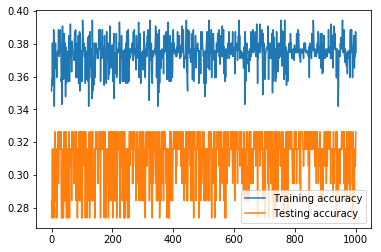

In [22]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

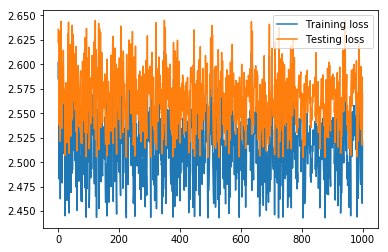

In [23]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()